# Future Exits Forcasting

### The task is to forcast the future exit count for any given turnstile and station
http://web.mta.info/developers/turnstile.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys
from functools import reduce
import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

### I. get Y2010-Y2017 data and calculate daily data

In [2]:
def get_data():
    if sys.platform == 'win32':
        path = 'C:/Users/liumh/OneDrive/two-sigma/data/'
    if sys.platform == 'linux':
        path = '/home/liumh/two-sigma/data/'
    dfs = []
    for year in range(2010, 2018):
        dfs.append(pd.read_csv(path + str(year) + '.csv.gz'))
    data = pd.concat(dfs)
    data.time = pd.to_datetime(data.time)
    data['date'] = data.time.dt.date
    data.sort_values('time', inplace = True)
    return data

def get_daily_data(data, start_date = datetime.datetime(2010,4,17), end_date = datetime.datetime(2017,9,23)):
    '''
    This function calculates daily entries and exits
    1. create a dataframe for all turnstiles and days between start date and end date
    2. sort data to be in ascending time order
    3. merge first record of each unique combinations of ['ca','scp','date'] with this dataframe and calculate daily data. 
       In this way, only adjacent dates will be used for calculating daily data. 
    4. Each day's data record should starts at 00:00:00, for days with first record after 4am, remove these days 
    '''
    ca_scp = data.ca +'_' + data.scp
    ca_scp = ca_scp.unique()
    
    dates = pd.date_range(start_date, end_date)
    dates = pd.DataFrame(dates)
    dates.columns = ['date']
    dates.date = dates.date.dt.date
    
    dfs = []
    for item in ca_scp:
        df = dates.copy()
        df['ca'] = item.split('_')[0]
        df['scp'] = item.split('_')[1]
        dfs.append(df)
    daily_data = pd.concat(dfs)
    daily = data.groupby(['ca','scp','date']).nth(0)
    daily = daily.reset_index()
    ########## each day starts at 00:00:00, only keep days with first record before 4am #########
    daily['hour'] = daily.time.dt.hour
    daily.loc[daily.hour >= 4, ['entries', 'exits']] = np.nan
    daily_data = daily_data.merge(daily, how = 'left', on = ['ca','scp','date'])
    daily_data.entries = daily_data[['ca', 'scp', 'entries']].groupby(['ca', 'scp']).entries.apply(lambda x: x.diff().shift(-1).abs())
    daily_data.exits = daily_data[['ca', 'scp', 'exits']].groupby(['ca', 'scp']).exits.apply(lambda x: x.diff().shift(-1).abs())
    return daily_data

def filter_data(df):
    '''
    define outliers as values beyond 5*IQR and set outliers to NaN, which will be removed later
    '''
    cols = ['ca', 'scp', 'entries', 'exits']
    Q1 = df[cols].groupby(['ca', 'scp']).quantile(0.1)
    Q3 = df[cols].groupby(['ca', 'scp']).quantile(0.9)
    IQR = Q3 - Q1
    Q1.columns = ['entries_Q1', 'exits_Q1']
    Q3.columns = ['entries_Q3', 'exits_Q3']
    IQR.columns = ['entries_IQR', 'exits_IQR']
    Q1 = Q1.reset_index()
    Q3 = Q3.reset_index()
    IQR = IQR.reset_index()
    dfs = [df, Q1, Q3, IQR]
    df = reduce(lambda left, right: pd.merge(left, right, how = 'left', on = ['ca', 'scp']), dfs)
    df['entries'][(df.entries < (df.entries_Q1 - 5 * df.entries_IQR)) 
                                           | (df.entries > (df.entries_Q3 + 5 * df.entries_IQR))] = np.nan
    df['exits'][(df.exits < (df.exits_Q1 - 5 * df.exits_IQR)) 
                                           | (df.exits > (df.exits_Q3 + 5 * df.exits_IQR))] = np.nan
    cols = ['entries_Q1', 'exits_Q1', 'entries_Q3', 'exits_Q3', 'entries_IQR', 'exits_IQR']
    df.drop(cols, axis = 1, inplace = True)
    return df

In [5]:
######### To save time and memory, get data and save daily data as csv file #########
data = get_data()
daily_data = get_daily_data(data, start_date = datetime.datetime(2010,4,17), end_date = datetime.datetime(2017,9,23))
# remove rows with NaN for both entries and exits
daily_data.dropna(subset = ['entries', 'exits'], how = 'all', inplace = True)
daily_data.to_csv('/home/liumh/two-sigma/data/daily_data.csv')

In [8]:
daily_data.head(2)

,date,ca,scp,desc,division,entries,exits,linename,station,time,unit,hour
1,2010-04-18,A002,02-00-00,REGULAR,BMT,485.0,156.0,456NQR,LEXINGTON AVE,2010-04-18,R051,0.0
2,2010-04-19,A002,02-00-00,REGULAR,BMT,1280.0,467.0,456NQR,LEXINGTON AVE,2010-04-19,R051,0.0


In [6]:
######### get daily data #########
daily_data = pd.read_csv('/home/liumh/two-sigma/data/daily_data.csv')
daily_data = daily_data.iloc[:, 1:]

### II. FeatureeEngineering Part 1
1. ca and scp uniquely identify single turnstile   
2. same ca and scp combinations may correspond to different station name, this is due to the change of station name at certain time. Moreover, many stations change name in year 2015. Thus, we can just use the latest station name so that each turnstile corresponds to a single station

### 1. time features 

In [7]:
######### remove outliers #########
daily_data = filter_data(daily_data)
daily_data.dropna(subset = ['exits'], inplace = True)

######### create time features #########
daily_data.time = pd.to_datetime(daily_data.time)
daily_data['date'] = daily_data.time.dt.date 
daily_data['dow'] = daily_data.time.dt.dayofweek                             # day of week
daily_data['moy'] = daily_data.time.dt.month                                 # month of year
daily_data['month'] = (daily_data.time.dt.year - 2010)*12 + daily_data.moy   # month number in the whole dataset

In [8]:
daily_data.shape,
daily_data.head(2)

,date,ca,scp,desc,division,entries,exits,linename,station,time,unit,hour,dow,moy,month
0,2010-04-18,A002,02-00-00,REGULAR,BMT,485.0,156.0,456NQR,LEXINGTON AVE,2010-04-18,R051,0.0,6,4,4
1,2010-04-19,A002,02-00-00,REGULAR,BMT,1280.0,467.0,456NQR,LEXINGTON AVE,2010-04-19,R051,0.0,0,4,4


In [7]:
daily_data.isnull().sum()

date            0
ca              0
scp             0
desc            0
division    68558
entries      6985
exits           0
linename    68558
station     68558
time            0
unit            0
hour            0
dow             0
moy             0
month           0
dtype: int64

### 2. use the latest station name so that each turnstile corresponds to a single station

In [8]:
# station, linename, division
info = daily_data.groupby(['ca','scp']).station.unique().reset_index()
info['num_station'] =  info.station.apply(lambda x: len(x))
info['latest_station'] = info.station.apply(lambda x: x[-1])
info = info.merge(daily_data.groupby(['ca','scp']).linename.unique().reset_index(), how = 'left', on = ['ca', 'scp'])
info = info.merge(daily_data.groupby(['ca','scp']).division.unique().reset_index(), how = 'left', on = ['ca', 'scp'])
info['num_linename'] = info.linename.apply(lambda x: len(x))
info['num_division'] = info.division.apply(lambda x: len(x))
info['latest_linename'] = info.linename.apply(lambda x: x[-1])
info['latest_division'] = info.division.apply(lambda x: x[-1])

info_sub = info[['ca', 'scp', 'latest_station', 'latest_linename', 'latest_division']]
info_sub.columns = ['ca', 'scp', 'station', 'linename', 'division']
daily_data.drop(['station', 'linename', 'division'], axis = 1, inplace = True)
daily_data = daily_data.merge(info_sub, how = 'left', on = ['ca', 'scp'])

In [8]:
turnstiles = daily_data[['ca', 'scp','station']]
turnstiles['ca_scp'] = daily_data.ca + '_' + daily_data.scp
turnstiles['ca_station'] = daily_data.ca + '_' + daily_data.station
turnstiles['scp_station'] = daily_data.scp + '_' + daily_data.station
turnstiles['ca_scp_station'] = daily_data.ca + '_' + daily_data.scp + '_' + daily_data.station
turnstiles.nunique()

ca                 746
scp                239
station            404
ca_scp            4994
ca_station         773
scp_station       4337
ca_scp_station    4986
dtype: int64

### 3. calculate start date and end date for each turnstile's daily data

In [9]:
########## calculate start_date and end_date for each turnstile's data #########
dates = daily_data.groupby(['ca', 'scp'], as_index = False).date.min()
dates = dates.merge(daily_data.groupby(['ca', 'scp'], as_index = False).date.max(), how = 'left', on = ['ca', 'scp'])
dates.columns = ['ca', 'scp', 'start_date', 'end_date']
dates['active_days'] = dates.end_date - dates.start_date
dates.active_days = dates.active_days.apply(lambda x: x.days)
dates.sort_values(['active_days'], inplace = True)
daily_data = daily_data.merge(dates, how = 'left', on = ['ca', 'scp'])
########### remove turnstiles with < 150 daily data #############
daily_data = daily_data[daily_data.active_days >= 150]  # total 74 turnstiles don't have enough data 
dates[dates.active_days < 150].shape

### 4. add holiday feature
**External data used for generating holiday feature**   
https://en.wikipedia.org/wiki/New_York_State_government_holidays   
https://en.wikipedia.org/wiki/Election_Day_(United_States)   
https://www.officeholidays.com/countries/usa/regional.php?list_year=2016&list_region=New%20York   

In [10]:
holidays = {}
holidays['2017'] = ['2017-01-02','2017-01-16','2017-02-13','2017-02-20','2017-05-29','2017-07-04', '2017-09-04','2017-10-09','2017-11-07','2017-11-11','2017-11-23','2017-12-25']
holidays['2016'] = ['2016-01-01','2016-01-18','2016-02-12','2016-02-15','2016-05-30','2016-07-04', '2016-09-05','2016-10-10','2016-11-08','2016-11-11','2016-11-24','2016-12-26']
holidays['2015'] = ['2015-01-01','2015-01-19','2015-02-12','2015-02-16','2015-05-25','2015-07-03', '2015-09-07','2015-10-12','2015-11-03','2015-11-11','2015-11-26','2015-12-25']
holidays['2014'] = ['2014-01-01','2014-01-20','2014-02-12','2014-02-17','2014-05-26','2014-07-04', '2014-09-01','2014-10-13','2014-11-04','2014-11-11','2014-11-27','2014-12-25']
holidays['2013'] = ['2013-01-01','2013-01-21','2013-02-12','2013-02-18','2013-05-27','2013-07-04', '2013-09-02','2013-10-14','2013-11-05','2013-11-11','2013-11-28','2013-12-25']
holidays['2012'] = ['2012-01-02','2012-01-16','2012-02-12','2012-02-20','2012-05-28','2012-07-04', '2012-09-03','2012-10-08','2012-11-06','2012-11-12','2012-11-22','2012-12-25']
holidays['2011'] = ['2011-01-17','2011-02-12','2011-02-21','2011-05-30','2011-07-04', '2011-09-05','2011-10-10','2011-11-08','2011-11-11','2011-11-24','2011-12-26']
holidays['2010'] = ['2010-01-01','2010-01-18','2010-02-12','2010-02-15','2010-05-31','2010-07-05', '2010-09-06','2010-10-11','2010-11-02','2010-11-11','2010-11-25','2010-12-24','2010-12-31']

def add_holiday_feature(df, weekend_flg = True):
    df['holiday_flg'] = np.zeros((df.shape[0], 1))
    years = range(2010, 2018)
    for year in years: 
        for i in holidays[str(year)]:
            date = pd.to_datetime(i).date()
            df.loc[df.date == date, 'holiday_flg'] = 1     
    if weekend_flg == True:
        df['holiday_flg2'] = df.holiday_flg
        df.loc[df.dow > 4, 'holiday_flg2'] = 1      # holiday_flg2=1 for both public holidays and weekends
    return df
daily_data = add_holiday_feature(daily_data, weekend_flg = True)

In [11]:
daily_data.head(2)

,date,ca,scp,desc,entries,exits,time,unit,hour,dow,moy,month,station,linename,division,start_date,end_date,active_days,holiday_flg,holiday_flg2
0,2010-04-18,A002,02-00-00,REGULAR,485.0,156.0,2010-04-18,R051,0.0,6,4,4,59 ST,NQR456W,BMT,2010-04-18,2017-09-22,2714,0.0,1.0
1,2010-04-19,A002,02-00-00,REGULAR,1280.0,467.0,2010-04-19,R051,0.0,0,4,4,59 ST,NQR456W,BMT,2010-04-18,2017-09-22,2714,0.0,0.0


** On average, exit count is much lower in holidays and weekends comparing with weekdays **

In [12]:
daily_data.groupby(['holiday_flg']).exits.mean()    # holiday_flg = 1 only for public holidays

holiday_flg
0.0    876.167051
1.0    647.686127
Name: exits, dtype: float64

In [13]:
daily_data.groupby(['holiday_flg2']).exits.mean()   # holiday_flg2=1 for both public holidays and weekends

holiday_flg2
0.0    999.960445
1.0    585.024883
Name: exits, dtype: float64

** As shown in below results, on average, exit count of public holidays is similar to weekends. Thus, we can set weekend's holiday_flg to 1, which results in holiday_flg2 and we will use holiday_flg2 for further feature engineering **

In [14]:
daily_data.groupby(['dow', 'holiday_flg']).exits.mean()   # holiday_flg = 1 only for public holidays

dow  holiday_flg
0    0.0             944.349197
     1.0             597.342623
1    0.0             999.250657
     1.0             852.440046
2    0.0            1021.552760
     1.0             692.408644
3    0.0            1023.821007
     1.0             578.994458
4    0.0            1005.303596
     1.0             716.137232
5    0.0             636.460666
     1.0             666.443926
6    0.0             520.551589
     1.0             500.157566
Name: exits, dtype: float64

In [15]:
daily_data.groupby(['dow', 'holiday_flg2']).exits.mean()   # holiday_flg2 = 1 for both public holidays and weekends

dow  holiday_flg2
0    0.0              944.349197
     1.0              597.342623
1    0.0              999.250657
     1.0              852.440046
2    0.0             1021.552760
     1.0              692.408644
3    0.0             1023.821007
     1.0              578.994458
4    0.0             1005.303596
     1.0              716.137232
5    1.0              636.537686
6    1.0              520.499810
Name: exits, dtype: float64

### II. FeatureeEngineering Part 2

<img src="image.png">
<caption><center> Feature collection in a rolling manner with varying statistics window lengths </center></caption>


1. **Rolling window (28 days)**: A fixed time interval of 28 days, data in this interval will not be included in constructing feature vectors.


2. **Statistics window**: Only data present in this window will be used for constructing feature vectors. The goal is to predict the next 28 days' exit counts (i.e., days in rolling window) given the feature values constructed from previous data. The size of statistics window varies from 28, 56, 28*6 days to 3000 days. The features capture recent trend and statistics, including min, max, mean, median, count, std and skew of exit counts group by turnstiles, turnstiles+dayofweek, turnstiles+holiday_flag, ca and ca+dayofweek. And by calculating these statistics on almost all historical data (3000 days), we can keep track of the overall trends and bounds.


3. **Index date**: index date seperates data in rolling window and historical data for constructing features. Note that the date of the last exit count of different turnstile maybe different, so the index date is obtained by substracting 28*N days from the date of the last exit count of each turnstile. Here, N ranges from 1 to 60. And we can increase N to use more data for constructing the dataset for modeling.

In [3]:
###################################### functions for generating features #########################################
def concat(result):
    df = None
    for item in result:
        if df is None:
            df = item
        else:
            try:
                df[item.columns] = item
            except:
                print(item.head())
    return df

def left_merge(df1, df2, on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(df2.columns)) != set(on):
        df2 = df2.reset_index()
    columns = [col for col in df2.columns if col not in on]
    result = df1.merge(df2, how = 'left', on = on)
    result = result[columns]
    return result

def get_subset(daily, n_days):
    # get subset in rolling window
    daily['end_date'] = daily.index_date + datetime.timedelta(days = n_days)
    subset = daily[(daily.date > daily.index_date) & (daily.date <= daily.end_date)].copy()
    subset.drop(['index_date', 'end_date'], axis = 1, inplace = True)
    subset.reset_index(drop=True, inplace = True)
    return subset

def get_turnstile_feat(subset, n_days):
    # exit counts group by turnstiles
    daily['start_date'] = daily.index_date + datetime.timedelta(days = -n_days)
    temp = daily[(daily.date <= daily.index_date) & (daily.date > daily.start_date)].copy()
    result = temp.groupby(['ca', 'scp'], as_index = False).exits.agg({'turnstile_min{}'.format(n_days): 'min',
                                                                      'turnstile_mean{}'.format(n_days): 'mean',
                                                                      'turnstile_median{}'.format(n_days): 'median',
                                                                      'turnstile_max{}'.format(n_days): 'max',
                                                                      'turnstile_count{}'.format(n_days): 'count',
                                                                      'turnstile_std{}'.format(n_days): 'std',
                                                                      'turnstile_skew{}'.format(n_days): 'skew'})
    result = left_merge(subset, result, on = ['ca', 'scp'])
    result.fillna(0, inplace = True)
    return result

def get_turnstile_week_feat(subset, n_days):
    # exit counts group by turnstiles and dayofweek
    daily['start_date'] = daily.index_date + datetime.timedelta(days = -n_days)
    temp = daily[(daily.date <= daily.index_date) & (daily.date > daily.start_date)].copy()
    result = temp.groupby(['ca', 'scp', 'dow'], as_index = False).exits.agg({'turnstile_dow_min{}'.format(n_days): 'min',
                                                                             'turnstile_dow_mean{}'.format(n_days): 'mean',
                                                                             'turnstile_dow_median{}'.format(n_days): 'median',
                                                                             'turnstile_dow_max{}'.format(n_days): 'max',
                                                                             'turnstile_dow_count{}'.format(n_days): 'count',
                                                                             'turnstile_dow_std{}'.format(n_days): 'std',
                                                                             'turnstile_dow_skew{}'.format(n_days): 'skew'})
    result = left_merge(subset, result, on = ['ca', 'scp', 'dow'])
    result.fillna(0, inplace = True)
    return result

def get_turnstile_holiday_feat(subset, n_days):
    # exit counts group by turnstiles and holiday_flg2
    daily['start_date'] = daily.index_date + datetime.timedelta(days = -n_days)
    temp = daily[(daily.date <= daily.index_date) & (daily.date > daily.start_date)].copy()
    result = temp.groupby(['ca', 'scp', 'holiday_flg2'], as_index = False).exits.agg(
        {'turnstile_holiday2_min{}'.format(n_days): 'min',
         'turnstile_holiday2_mean{}'.format(n_days): 'mean',
         'turnstile_holiday2_median{}'.format(n_days): 'median',
         'turnstile_holiday2_max{}'.format(n_days): 'max',
         'turnstile_holiday2_count{}'.format(n_days): 'count',
         'turnstile_holiday2_std{}'.format(n_days): 'std',
         'turnstile_holiday2_skew{}'.format(n_days): 'skew'})
    result = left_merge(subset, result, on=['ca', 'scp', 'holiday_flg2'])
    result.fillna(0, inplace = True)
    return result

def get_ca_feat(subset, n_days):
    # exit counts group by ca
    daily['start_date'] = daily.index_date + datetime.timedelta(days = -n_days)
    temp = daily[(daily.date <= daily.index_date) & (daily.date > daily.start_date)].copy()
    result = temp.groupby(['ca'], as_index = False).exits.agg({'ca_min{}'.format(n_days): 'min',
                                                               'ca_mean{}'.format(n_days): 'mean',
                                                               'ca_median{}'.format(n_days): 'median',
                                                               'ca_max{}'.format(n_days): 'max',
                                                               'ca_count{}'.format(n_days): 'count',
                                                               'ca_std{}'.format(n_days): 'std',
                                                               'ca_skew{}'.format(n_days): 'skew'})
    result = left_merge(subset, result, on = ['ca'])
    result.fillna(0, inplace = True)
    return result

def get_ca_week_feat(subset, n_days):
    # exit counts group by ca and dayofweek
    daily['start_date'] = daily.index_date + datetime.timedelta(days = -n_days)
    temp = daily[(daily.date <= daily.index_date) & (daily.date > daily.start_date)].copy()
    result = temp.groupby(['ca', 'dow'], as_index = False).exits.agg({'ca_dow_min{}'.format(n_days): 'min',
                                                                       'ca_dow_mean{}'.format(n_days): 'mean',
                                                                       'ca_dow_median{}'.format(n_days): 'median',
                                                                       'ca_dow_max{}'.format(n_days): 'max',
                                                                       'ca_dow_count{}'.format(n_days): 'count',
                                                                       'ca_dow_std{}'.format(n_days): 'std',
                                                                       'ca_dow_skew{}'.format(n_days): 'skew'})
    result = left_merge(subset, result, on = ['ca', 'dow'])
    result.fillna(0, inplace = True)
    return result

def make_feats(df, n_days):
    print('making features')
    subset = get_subset(df, n_days)
    result = [subset]
    result.append(get_turnstile_feat(subset, 3000))             # turnstile features
    result.append(get_turnstile_feat(subset, 28*6))             # turnstile features
    result.append(get_turnstile_feat(subset, 56))               # turnstile features
    result.append(get_turnstile_feat(subset, 28))               # turnstile features

    result.append(get_turnstile_week_feat(subset, 3000))        # turnstile dayofweek features
    result.append(get_turnstile_week_feat(subset, 28*6))        # turnstile dayofweek features
    result.append(get_turnstile_week_feat(subset, 56))          # turnstile dayofweek features
    result.append(get_turnstile_week_feat(subset, 28))          # turnstile dayofweek features
    
    result.append(get_turnstile_holiday_feat(subset, 3000))     # turnstile holiday features
    result.append(get_turnstile_holiday_feat(subset, 28*12))    # turnstile holiday features
    
    result.append(get_ca_feat(subset, 3000))              # ca features
    result.append(get_ca_feat(subset, 28*6))              # ca features
    result.append(get_ca_feat(subset, 56))                # ca features
    result.append(get_ca_feat(subset, 28))                # ca features

    result.append(get_ca_week_feat(subset, 3000))         # ca dayofweek features
    result.append(get_ca_week_feat(subset, 28*6))         # ca dayofweek features
    result.append(get_ca_week_feat(subset, 56))           # ca dayofweek features
    result.append(get_ca_week_feat(subset, 28))           # ca dayofweek features

    result = concat(result)
    print('data shape：{}'.format(result.shape))
    return result

In [13]:
daily_data.columns, len(daily_data.columns), daily_data.shape

(Index(['date', 'ca', 'scp', 'desc', 'entries', 'exits', 'time', 'unit', 'hour',
        'dow', 'moy', 'month', 'station', 'linename', 'division', 'start_date',
        'end_date', 'active_days', 'holiday_flg', 'holiday_flg2'],
       dtype='object'), 20, (11845749, 20))

In [14]:
daily_data.drop(['time', 'unit', 'entries', 'desc', 'hour', 'active_days', 'holiday_flg'], axis = 1, inplace = True)
data = pd.DataFrame()
for i in range(1, 61):
    print(i)
    daily_data['index_date'] = daily_data.end_date + datetime.timedelta(days = -28*i)
    daily = daily_data.drop(['start_date', 'end_date'], axis = 1).copy()
    sub = make_feats(daily, 28)
    data = pd.concat([data, sub])

1
making features
data shape：(136359, 137)
2
making features
data shape：(135799, 137)
3
making features
data shape：(135380, 137)
4
making features
data shape：(135831, 137)
5
making features
data shape：(134952, 137)
6
making features
data shape：(135325, 137)
7
making features
data shape：(135148, 137)
8
making features
data shape：(134655, 137)
9
making features
data shape：(133660, 137)
10
making features
data shape：(132518, 137)
11
making features
data shape：(132028, 137)
12
making features
data shape：(131739, 137)
13
making features
data shape：(131748, 137)
14
making features
data shape：(131602, 137)
15
making features
data shape：(130939, 137)
16
making features
data shape：(130974, 137)
17
making features
data shape：(130750, 137)
18
making features
data shape：(130075, 137)
19
making features
data shape：(130593, 137)
20
making features
data shape：(130362, 137)
21
making features
data shape：(129447, 137)
22
making features
data shape：(129637, 137)
23
making features
data shape：(129617, 13

#### Label encoding categorical features

In [29]:
from sklearn.preprocessing import LabelEncoder
for col in ['ca', 'scp', 'station', 'division', 'linename']:
    data[col] = data[col].astype(str)
    data[col] = LabelEncoder().fit_transform(data[col])
data.to_csv('/home/liumh/two-sigma/data/data_only_holiday_flg2.csv')

In [ ]:
data = pd.read_csv('/home/liumh/two-sigma/data/data_only_holiday_flg2.csv')
data = data.iloc[:, 1:]
data.date = pd.to_datetime(data.date)
data.date = data.date.dt.date
data.end_date = pd.to_datetime(data.end_date)
data.end_date = data.end_date.dt.date
data.head(2)

#### Train test split
The cutoff date that seperates train and test data is 28 days before the date of the last exit count of each turnstile.

In [ ]:
data.end_date = date.end_date + datetime.timedelta(days = -28)
train = data[data.date <= data.end_date]
test = data[data.date > data.end_date]
########## save train and test data to disk to save memory   ##############
train.to_csv('/home/liumh/two-sigma/data/train.csv')
test.to_csv('/home/liumh/two-sigma/data/test.csv')

## III. Modeling

#### Prepare train and test data

In [19]:
train = pd.read_csv('/home/liumh/two-sigma/data/train.csv')
test = pd.read_csv('/home/liumh/two-sigma/data/test.csv')
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
train.drop(['date', 'end_date'], axis = 1, inplace = True)
test.drop(['date', 'end_date'], axis = 1, inplace = True)

In [6]:
train.shape, test.shape

((7496775, 136), (136359, 136))

In [8]:
test.head(2)

,ca,scp,exits,dow,moy,month,station,linename,division,holiday_flg2,...,ca_dow_count56,ca_dow_std56,ca_dow_skew56,ca_dow_min28,ca_dow_mean28,ca_dow_median28,ca_dow_max28,ca_dow_count28,ca_dow_std28,ca_dow_skew28
0,0,113,215.0,5,8,92,88,107,0,1.0,...,96.0,375.658178,0.911910,0.0,325.729167,172.5,1190.0,48.0,378.183550,0.976354
1,0,113,175.0,6,8,92,88,107,0,1.0,...,96.0,320.114759,0.957038,0.0,274.208333,143.0,952.0,48.0,319.252848,0.991507


In [10]:
train.columns[:20]

Index(['ca', 'scp', 'exits', 'dow', 'moy', 'month', 'station', 'linename',
       'division', 'holiday_flg2', 'turnstile_min3000', 'turnstile_mean3000',
       'turnstile_median3000', 'turnstile_max3000', 'turnstile_count3000',
       'turnstile_std3000', 'turnstile_skew3000', 'turnstile_min168',
       'turnstile_mean168', 'turnstile_median168'],
      dtype='object')

#### LightGBM regressor model for train and prediction

In [11]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
# LGBMRegressor.fit?

In [12]:
categoricals = ['ca', 'scp', 'dow', 'moy', 'month', 'station', 'linename', 'division', 'holiday_flg2']
model = LGBMRegressor(n_estimators = 10000, 
                      max_depth = 20, 
                      learning_rate = 0.01, 
                      subsample = 0.8,
                      colsample_bytree = 0.8, 
                      early_stopping_round = 100)         
# use early stopping to reduce overfitting and get the best number of n_estimators

model.fit(train.drop('exits', axis = 1), train.exits, 
          eval_set = (test.drop('exits', axis = 1), test.exits), 
          eval_metric = 'l2',     # l2 is mean squared error in lightgbm
          categorical_feature = categoricals, 
          verbose = 1)

pred = model.predict(test.drop('exits', axis = 1))
# pred.to_csv('/home/liumh/two-sigma/data/pred.csv')

[1]	valid_0's l2: 913876
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 897250
[3]	valid_0's l2: 880868
[4]	valid_0's l2: 864890
[5]	valid_0's l2: 849161
[6]	valid_0's l2: 833684
[7]	valid_0's l2: 818542
[8]	valid_0's l2: 803697
[9]	valid_0's l2: 789204
[10]	valid_0's l2: 774944
[11]	valid_0's l2: 761184
[12]	valid_0's l2: 747510
[13]	valid_0's l2: 734014
[14]	valid_0's l2: 720832
[15]	valid_0's l2: 707906
[16]	valid_0's l2: 695205
[17]	valid_0's l2: 682984
[18]	valid_0's l2: 670716
[19]	valid_0's l2: 658732
[20]	valid_0's l2: 646956
[21]	valid_0's l2: 635541
[22]	valid_0's l2: 624277
[23]	valid_0's l2: 613305
[24]	valid_0's l2: 602522
[25]	valid_0's l2: 591829
[26]	valid_0's l2: 581444
[27]	valid_0's l2: 571213
[28]	valid_0's l2: 561258
[29]	valid_0's l2: 551474
[30]	valid_0's l2: 541814
[31]	valid_0's l2: 532381
[32]	valid_0's l2: 523159
[33]	valid_0's l2: 514113
[34]	valid_0's l2: 505274
[35]	valid_0's l2: 496584
[36]	valid_0's l2: 488031
[37]	valid

[302]	valid_0's l2: 57216.4
[303]	valid_0's l2: 57156.6
[304]	valid_0's l2: 57081.3
[305]	valid_0's l2: 57034
[306]	valid_0's l2: 56987.2
[307]	valid_0's l2: 56919.3
[308]	valid_0's l2: 56870.9
[309]	valid_0's l2: 56817.7
[310]	valid_0's l2: 56773.6
[311]	valid_0's l2: 56719.4
[312]	valid_0's l2: 56675
[313]	valid_0's l2: 56623.3
[314]	valid_0's l2: 56594.5
[315]	valid_0's l2: 56543
[316]	valid_0's l2: 56497.7
[317]	valid_0's l2: 56451.9
[318]	valid_0's l2: 56407.3
[319]	valid_0's l2: 56372
[320]	valid_0's l2: 56329.3
[321]	valid_0's l2: 56275.5
[322]	valid_0's l2: 56236.7
[323]	valid_0's l2: 56190.3
[324]	valid_0's l2: 56148.4
[325]	valid_0's l2: 56105.6
[326]	valid_0's l2: 56066.3
[327]	valid_0's l2: 56032.2
[328]	valid_0's l2: 55969.3
[329]	valid_0's l2: 55933.7
[330]	valid_0's l2: 55895.5
[331]	valid_0's l2: 55860.9
[332]	valid_0's l2: 55805.7
[333]	valid_0's l2: 55777.3
[334]	valid_0's l2: 55754.4
[335]	valid_0's l2: 55698.3
[336]	valid_0's l2: 55646.7
[337]	valid_0's l2: 55610.7


[597]	valid_0's l2: 51714.1
[598]	valid_0's l2: 51713.8
[599]	valid_0's l2: 51716.3
[600]	valid_0's l2: 51708.6
[601]	valid_0's l2: 51706.4
[602]	valid_0's l2: 51707.3
[603]	valid_0's l2: 51705.9
[604]	valid_0's l2: 51693.8
[605]	valid_0's l2: 51688.8
[606]	valid_0's l2: 51678.9
[607]	valid_0's l2: 51672.7
[608]	valid_0's l2: 51667.8
[609]	valid_0's l2: 51662.2
[610]	valid_0's l2: 51663.9
[611]	valid_0's l2: 51645.8
[612]	valid_0's l2: 51632.2
[613]	valid_0's l2: 51643
[614]	valid_0's l2: 51637.5
[615]	valid_0's l2: 51638
[616]	valid_0's l2: 51638.6
[617]	valid_0's l2: 51639.6
[618]	valid_0's l2: 51633.5
[619]	valid_0's l2: 51630.9
[620]	valid_0's l2: 51624.4
[621]	valid_0's l2: 51622.6
[622]	valid_0's l2: 51618.1
[623]	valid_0's l2: 51615.5
[624]	valid_0's l2: 51616.1
[625]	valid_0's l2: 51598.8
[626]	valid_0's l2: 51592.8
[627]	valid_0's l2: 51584.5
[628]	valid_0's l2: 51584.1
[629]	valid_0's l2: 51582.1
[630]	valid_0's l2: 51579.6
[631]	valid_0's l2: 51561.7
[632]	valid_0's l2: 5155

[892]	valid_0's l2: 51039.2
[893]	valid_0's l2: 51037.8
[894]	valid_0's l2: 51029.3
[895]	valid_0's l2: 51028.3
[896]	valid_0's l2: 51033
[897]	valid_0's l2: 51031.3
[898]	valid_0's l2: 51032.2
[899]	valid_0's l2: 51048.2
[900]	valid_0's l2: 51045.5
[901]	valid_0's l2: 51044.7
[902]	valid_0's l2: 51044.5
[903]	valid_0's l2: 51045.4
[904]	valid_0's l2: 51045.4
[905]	valid_0's l2: 51044.2
[906]	valid_0's l2: 51042.3
[907]	valid_0's l2: 51041.1
[908]	valid_0's l2: 51032.5
[909]	valid_0's l2: 51018.8
[910]	valid_0's l2: 51019.6
[911]	valid_0's l2: 51019.1
[912]	valid_0's l2: 51018.8
[913]	valid_0's l2: 51019.1
[914]	valid_0's l2: 51019.6
[915]	valid_0's l2: 51018.3
[916]	valid_0's l2: 51015.1
[917]	valid_0's l2: 51014.5
[918]	valid_0's l2: 51002.7
[919]	valid_0's l2: 50999.5
[920]	valid_0's l2: 50997.3
[921]	valid_0's l2: 50995.6
[922]	valid_0's l2: 50997.8
[923]	valid_0's l2: 50996.6
[924]	valid_0's l2: 50996.7
[925]	valid_0's l2: 51000.9
[926]	valid_0's l2: 51010.1
[927]	valid_0's l2: 51

#### Mean squared error of prediction

In [99]:
mse_score = mean_squared_error(test.exits.values, pred)
print('mean square error of prediction on test set is ' + str(mse_score))

mean square error of prediction on test set is 51389.33330209706


In [101]:
train_pred = model.predict(train.drop('exits', axis = 1))
print('mean square error of prediction on training set is ' + str(mean_squared_error(train.exits.values, train_pred)))

mean square error of prediction on training set is 37576.02847117766


#### Feature importance in descending order

In [110]:
pd.set_option('display.max_rows', 500)
columns = pd.DataFrame(train.drop('exits', axis = 1).columns.tolist())
feature_importance = pd.concat([columns, pd.DataFrame(model.feature_importances_)], axis = 1)
feature_importance.columns = ['column_name', 'importance']
feature_importance.sort_values('importance', ascending=False)

,column_name,importance
4,month,4467
0,ca,3286
2,dow,1835
73,turnstile_holiday2_mean336,992
1,scp,991
61,turnstile_dow_max28,874
60,turnstile_dow_median28,830
3,moy,827
59,turnstile_dow_mean28,772
74,turnstile_holiday2_median336,762


#### Scatter plot part of the predictions (red dots) versus true values (cyan dots)

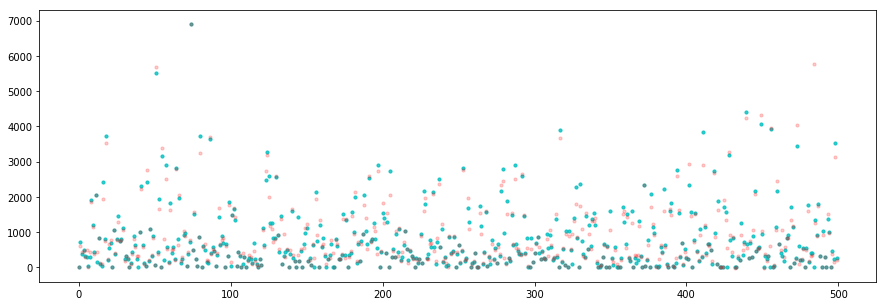

In [111]:
index = np.random.randint(1, len(pred), 500)    # random select 1000 data 
plt.figure(figsize=(15, 5))
plt.scatter(range(len(index)), test.exits.values[index], s = 10, c = 'c', alpha = 0.8)
plt.scatter(range(len(index)), pred[index], s = 10, c = 'r', alpha = 0.2)